# Breve Explicacion
El objetivo de este cuaderno es entrenar la primera etapa del Filtro Bietápico, para luego compararlo con el monoetápico y escoger el mejor sistema. 

# Montaje e Importación 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from matplotlib import pyplot as plt
from keras import applications

In [ ]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

     |████████████████████████████████| 1.8MB 10.8MB/s 
     |████████████████████████████████| 174kB 36.4MB/s 
     |████████████████████████████████| 133kB 35.8MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Modelo

In [ ]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 2 
BATCH_SIZE = 32 

In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train_filter_set_v2.csv")
df_test=pd.read_csv("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test_filter_set_v2.csv")

In [ ]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255,horizontal_flip=True,rotation_range=40)
dir = '/content/'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='Path',y_col='class_name',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 15762 validated image filenames belonging to 2 classes.


In [ ]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='Path',y_col='class_name',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3940 validated image filenames belonging to 2 classes.


In [ ]:
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) )
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(NUM_CLASSES , activation= 'sigmoid')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
run = wandb.init(project='filter',
                 config={  
                     "learning_rate": 0.0001,
                     "epochs": 30,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "resnet50",
                     "dataset": "PA - Filtering"
                 })
config = wandb.config

In [ ]:
history = model.fit(train_batches, 
                    validation_data = valid_batches ,
                    epochs=config.epochs, 
          batch_size=config.batch_size, workers=8,
           callbacks=[EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),WandbCallback()])

Epoch 1/30
493/493 [==============================] - 866s 2s/step - loss: 0.1046 - accuracy: 0.9582 - val_loss: 0.4044 - val_accuracy: 0.8772
Epoch 2/30
493/493 [==============================] - 173s 345ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.2362 - val_accuracy: 0.8926
Epoch 3/30
493/493 [==============================] - 170s 341ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 4/30
493/493 [==============================] - 170s 341ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.0014 - val_accuracy: 0.9992
Epoch 5/30
493/493 [==============================] - 169s 340ms/step - loss: 0.0030 - accuracy: 0.9985 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 6/30
493/493 [==============================] - 169s 339ms/step - loss: 0.0019 - accuracy: 0.9991 - val_loss: 2.6836e-04 - val_accuracy: 1.0000
Epoch 7/30
493/493 [==============================] - 171s 341ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 8.5860e

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Filtro_Bietapico_Primero.h5')

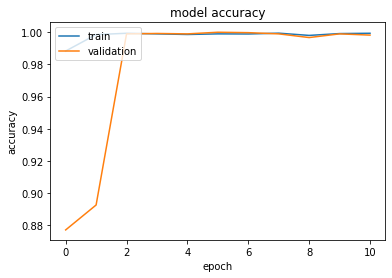

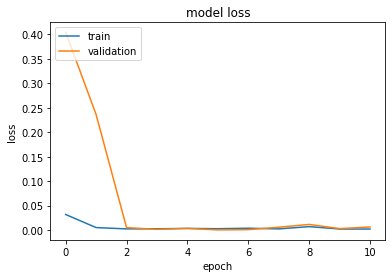

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# *Test*

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)#Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory='/content/',
    x_col='Path',y_col='class_name',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"#, validate_filenames=False
    )

Found 4928 validated image filenames belonging to 2 classes.


In [ ]:
  model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Filtro_Bietapico_Primero.h5')

In [ ]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4928/4928 [==============================] - 1449s 288ms/step
(4928, 2)


In [ ]:
#Calculamos la matriz de predicciones
#result_test=model.predict(test_batches, verbose=1)
print ("Loss = " + str(result_test[0]))
print ("Test Accuracy = " + str(result_test[1]))

Loss = [1.000000e+00 1.809709e-08]
Test Accuracy = [1.0000000e+00 1.9243998e-10]


In [ ]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(test_batches.class_indices.values(),test_batches.class_indices.keys()))
classes_dict

{0: 'Chest', 1: 'Otro'}

In [ ]:
#Obtenemos el índice de mayor score en cada fila (cada imagen)
preds = result_test.argmax(axis=-1)

In [ ]:
#Obtenemos el nombre de clase asignado a cada clase
preds_classes = [classes_dict[p] for p in preds]

In [ ]:
#Evaluar cuantas predicciones hay de cada clase
pd.Series(preds_classes).value_counts()

Chest    4358
Otro      570
dtype: int64

In [ ]:
import numpy as np
#Obtenemos el nombre de clase de la etiqueta verdadera (groun-truths)
gts = np.array([classes_dict[p] for p in test_batches.classes])

In [ ]:
#Evaluamos métricas de clasificación
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(gts,preds_classes))

              precision    recall  f1-score   support

       Chest       1.00      1.00      1.00      4360
        Otro       1.00      1.00      1.00       568

    accuracy                           1.00      4928
   macro avg       1.00      1.00      1.00      4928
weighted avg       1.00      1.00      1.00      4928



In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=16,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera', fontsize=16)
    plt.xlabel('Predicción del modelo', fontsize=16)
    plt.show()

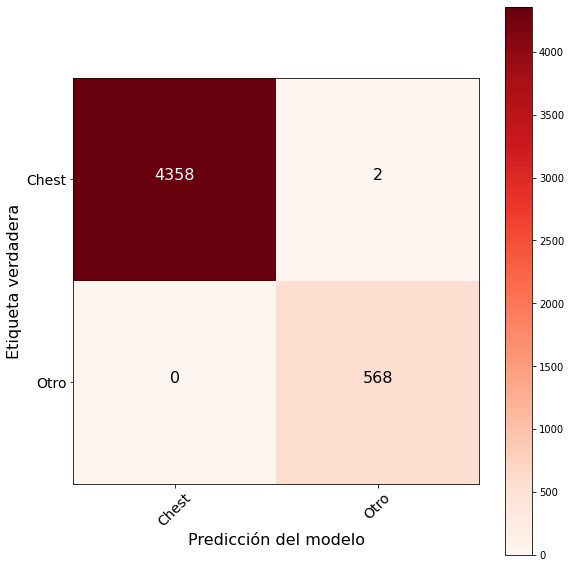

In [ ]:
confusionMatrix = confusion_matrix(gts,preds_classes)

plot_confusion_matrix(confusionMatrix,test_batches.class_indices.keys())

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [ ]:
y_test = pd.get_dummies(gts).to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


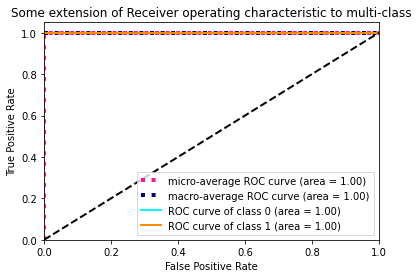

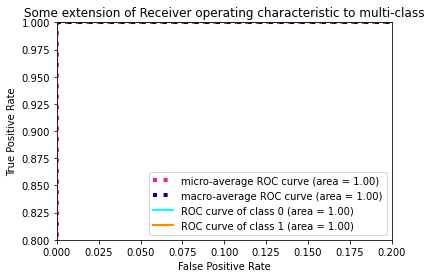

In [ ]:
y_score = result_test
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Y_test = pd.get_dummies(gts).to_numpy()
y_score = result_test

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])


# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

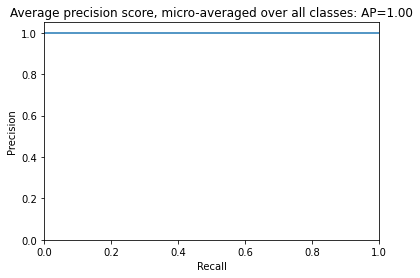

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

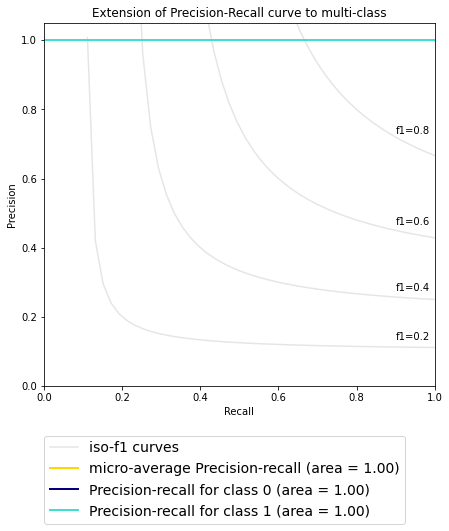

In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(NUM_CLASSES), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

# Analisis de Predicciones Incorrectas

In [ ]:
df_test["Pred"] = preds_classes
df_test["result"] = df_test["class_name"]==df_test["Pred"]
df_test_bad = df_test[df_test["result"]==False]
df_test_bad

,Unnamed: 0,Unnamed: 0.1,unnamed,Path,ImgType,class_name,Pred,result
3707,3707,4126,4126,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest,Otro,False
4002,4002,1172,1172,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,Chest,Otro,False


In [ ]:
df_test.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/df_test_w_results_chest_other.csv')

Ground Truth: Chest
Prediction: Otro


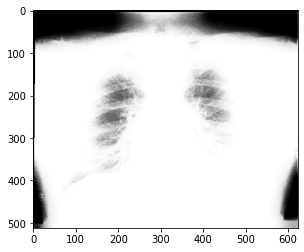

In [ ]:
from imageio import imread
ROW = 0
path_read = df_test_bad["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test_bad["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test_bad["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Otro


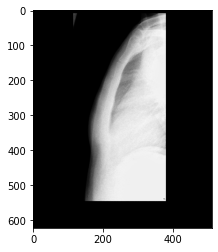

In [ ]:
ROW = 1
path_read = df_test_bad["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test_bad["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test_bad["Pred"].values[ROW])

# Analisis Predicciones Correctas


Ground Truth: Chest
Prediction: Chest


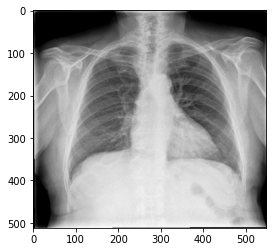

In [ ]:
ROW = 0
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


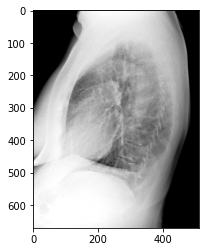

In [ ]:
ROW = 20
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


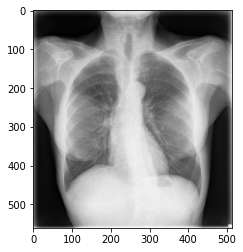

In [ ]:
ROW = 180
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


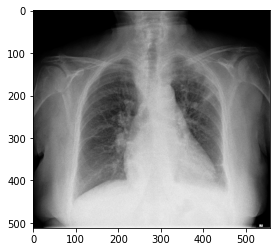

In [ ]:
ROW = 450
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


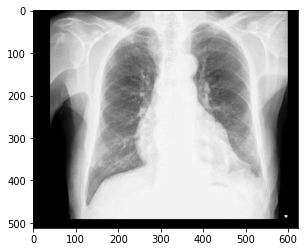

In [ ]:
ROW = 901
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


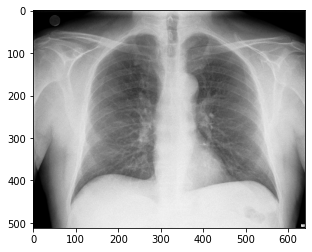

In [ ]:
ROW = 1032
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


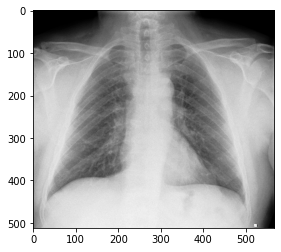

In [ ]:
ROW = 1230
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


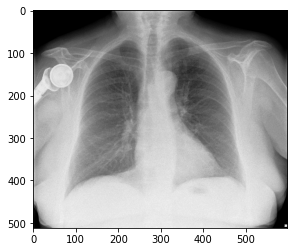

In [ ]:
ROW = 2000
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


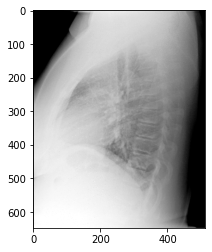

In [ ]:
ROW = 2100
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


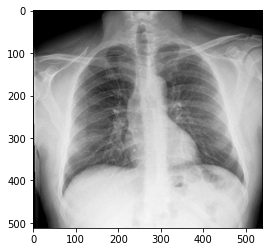

In [ ]:
ROW = 2678
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


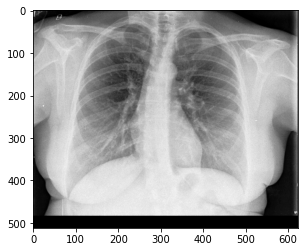

In [ ]:
ROW = 3000
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


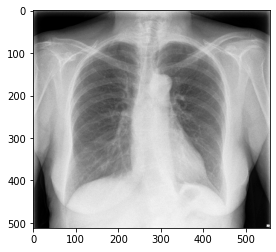

In [ ]:
ROW = 3111
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


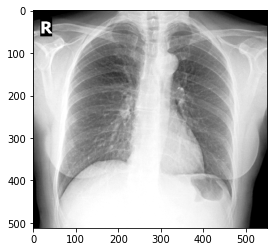

In [ ]:
ROW = 3220
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Chest
Prediction: Chest


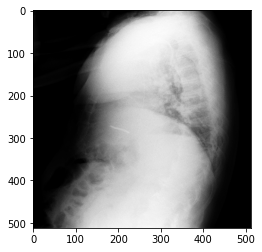

In [ ]:
ROW = 4500
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])

Ground Truth: Otro
Prediction: Otro


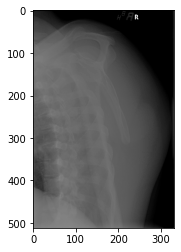

In [ ]:
ROW = 55
path_read = df_test["Path"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen,cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["class_name"].values[ROW]+'\n'+'Prediction: ' + df_test["Pred"].values[ROW])